## Generating the Data

In [43]:
import pandas as pd
import random
from faker import Faker
from faker import Faker
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

# Initialize Faker instance
fake = Faker()

# Generate Customer Demographics Data
def generate_customer_demographics(num_customers=1000):
    customer_data = []
    for _ in range(num_customers):
        customer = {
            'customer_id': fake.uuid4(),
            'name': fake.name(),
            'age': random.randint(18, 70),
            'gender': random.choice(['Male', 'Female']),
            'marital_status': random.choice(['Single', 'Married', 'Divorced']),
            'education': random.choice(['High School', 'Bachelor', 'Master', 'PhD']),
            'occupation': fake.job(),
            'salary': random.randint(20000, 150000),  # Yearly salary
        }
        customer_data.append(customer)
    return pd.DataFrame(customer_data)

# Generate Customer Financial Behavior Data
def generate_financial_behavior(customer_ids, num_records=2000):
    financial_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        loan_amount = random.randint(5000, 500000) if product_type != 'Credit Card' else random.randint(5000, 150000)
        credit_limit = random.randint(1000, 150000) if product_type == 'Credit Card' else None
        utilization = random.uniform(0.1, 1.0) if product_type == 'Credit Card' else None
        max_dpd = random.choice([0, 15, 30, 60, 90, 120])
        default_status = random.choice([True, False])

        financial_behavior = {
            'customer_id': random.choice(customer_ids),
            'product_type': product_type,
            'loan_amount': loan_amount,
            'credit_limit': credit_limit,
            'credit_utilization': utilization,
            'emi_paid': random.randint(1, 24),
            'tenure_months': random.randint(12, 60),
            'max_dpd': max_dpd,
            'default_status': default_status
        }
        financial_data.append(financial_behavior)
    return pd.DataFrame(financial_data)

# Generate Customer Enquiries Data (Last 3 months)
def generate_customer_enquiries(customer_ids, num_records=500):
    enquiries_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        enquiry_amount = random.randint(5000, 500000) if product_type != 'Credit Card' else random.randint(5000, 100000)
        enquiry = {
            'customer_id': random.choice(customer_ids),
            'enquiry_date': fake.date_between(start_date='-90d', end_date='today'),
            'product_type': product_type,
            'enquiry_amount': enquiry_amount,
            'status': random.choice(['Approved', 'Rejected'])
        }
        enquiries_data.append(enquiry)
    return pd.DataFrame(enquiries_data)

# Generate Customer Transaction Data (Past 6 months)
def generate_customer_transactions(customer_ids, num_records=5000):
    transactions_data = []
    for _ in range(num_records):
        transaction_date = fake.date_between(start_date='-180d', end_date='today')
        transaction_amount = random.uniform(50, 10000)
        
        # Transaction description with salary-related and hobby keywords
        transaction_description = random.choice([
            'Salary from XYZ Corp', 'Amazon Purchase', 'Grocery Store', 'Gym Membership',
            'Netflix Subscription', 'Restaurant', 'Fuel Station', 'Travel Booking', 
            'SALARY - ABC Corp', 'SAL credited from DEF Ltd', 'Monthly Salary GHI Pvt Ltd', 
            'Rent Payment', 'Car Insurance', 'Mobile Phone Bill', 'Electricity Bill', 'Spotify Subscription',
            'Uber Ride', 'Etsy Shopping', 'Concert Ticket', 'Books Purchase'
        ])

        # Salary detection
        salary_keywords = ['Salary', 'SALARY', 'SAL', 'SAL credited', 'Monthly Salary']
        is_salary = any(keyword in transaction_description.upper() for keyword in salary_keywords)

        # Hobbies detection based on transaction descriptions
        hobbies = None
        if "Amazon" in transaction_description or "Etsy" in transaction_description:
            hobbies = 'Shopping'
        elif "Netflix" in transaction_description or "Spotify" in transaction_description:
            hobbies = 'Entertainment'
        elif "Gym" in transaction_description:
            hobbies = 'Fitness'
        elif "Concert" in transaction_description:
            hobbies = 'Music'
        elif "Books" in transaction_description:
            hobbies = 'Reading'
        elif "Travel" in transaction_description or "Uber Ride" in transaction_description:
            hobbies = 'Travel'

        transaction = {
            'customer_id': random.choice(customer_ids),
            'transaction_date': transaction_date,
            'transaction_amount': transaction_amount,
            'transaction_description': transaction_description,
            'account_balance': random.uniform(500, 20000),
            'is_salary': is_salary,
            'hobby_detected': hobbies
        }
        transactions_data.append(transaction)

    return pd.DataFrame(transactions_data)

# Generate consistent data across all categories
customers = generate_customer_demographics(5000)
financial_behavior = generate_financial_behavior(customers['customer_id'], num_records=15000)
enquiries = generate_customer_enquiries(customers['customer_id'], num_records=4000)
transactions = generate_customer_transactions(customers['customer_id'], num_records=20000)

In [44]:
!pip install faker


In [45]:
# Combine Data for Clustering
# Aggregating financial and transaction data by customer_id to create summary features
financial_summary = financial_behavior.groupby('customer_id').agg({
    'loan_amount': 'mean',
    'credit_limit': 'mean',
    'credit_utilization': 'mean',
    'emi_paid': 'sum',
    'tenure_months': 'mean',
    'max_dpd': 'max',
    'default_status': 'mean',
    'product_type':'unique'
}).reset_index()

transaction_summary = transactions.groupby('customer_id').agg({
    'transaction_amount': 'mean',
    'account_balance': 'mean',
    'is_salary': 'sum',
    'transaction_amount': lambda x: x[transactions['is_salary'] == 1].sum()
}).reset_index()

# Assuming 'enquiries' has columns like ['customer_id', 'product_type', 'enquiry_date', 'enquiry_amount']
enquiries_summary = enquiries.groupby('customer_id').agg({
    'enquiry_amount': 'mean',  # Average amount enquired
    'product_type': lambda x: x.nunique(),  # Number of unique products enquired
    'customer_id': 'count'  # Total number of enquiries
}).rename(columns={
    'customer_id': 'total_enquiries',
    'product_type': 'unique_products_enquired'
}).reset_index()

# Merging demographics, financial behavior, and transaction summary
merged_data = pd.merge(customers, financial_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, enquiries_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, transaction_summary, on='customer_id', how='left')

In [46]:
merged_data.head()

,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,...,tenure_months,max_dpd,default_status,product_type,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary
0,344e452a-50f1-48fe-bdf2-ded44b7d6d8e,Tammy Zamora,18,Female,Single,Bachelor,Recruitment consultant,67155,192855.200000,102297.666667,...,39.4,120.0,0.600000,"[Credit Card, Home Loan]",NaN,NaN,NaN,6905.423114,12242.171606,1.0
1,268a4133-0ec1-4798-8e67-5f8b7c44f7b0,Thomas Graham,51,Female,Married,High School,"Accountant, chartered",42140,166760.625000,69996.750000,...,35.0,120.0,0.375000,"[Personal Loan, Credit Card, Home Loan]",19477.0,1.0,1.0,4791.816087,14082.353383,1.0
2,5a229ed3-f83b-472a-aa7b-9fbea1cfc5d7,Mary Johnson,46,Male,Single,PhD,Operational researcher,129956,118849.000000,7261.000000,...,36.0,60.0,1.000000,[Credit Card],77481.0,1.0,1.0,2746.955610,9990.991294,1.0
3,3e142dc4-d97e-4b6b-b0cf-a3bfed033f7d,Patrick Perez,51,Male,Married,Master,Market researcher,77684,400613.333333,NaN,...,33.0,120.0,0.666667,"[Home Loan, Personal Loan]",35480.0,2.0,3.0,0.000000,16584.656934,0.0
4,f97bb753-d96f-4de1-8b8e-af473399abfd,Nicholas Martinez,48,Male,Single,PhD,Film/video editor,119862,399491.000000,NaN,...,24.0,0.0,1.000000,[Personal Loan],NaN,NaN,NaN,0.000000,16188.782592,0.0


In [47]:
# Step 1: Explode the list in 'product_type' column
df_exploded = merged_data.explode('product_type')

# Step 2: One-hot encode the 'product_type' column
df_encoded = pd.get_dummies(df_exploded['product_type'])

merged_data = pd.concat([df_exploded, df_encoded], axis=1)

# Step 4: Group by the original index and aggregate to bring it back into one row per customer
df_final = merged_data.groupby(merged_data.index).sum()
df_final.columns

Index(['customer_id', 'name', 'age', 'gender', 'marital_status', 'education',
       'occupation', 'salary', 'loan_amount', 'credit_limit',
       'credit_utilization', 'emi_paid', 'tenure_months', 'max_dpd',
       'default_status', 'product_type', 'enquiry_amount',
       'unique_products_enquired', 'total_enquiries', 'transaction_amount',
       'account_balance', 'is_salary', 'Credit Card', 'Home Loan',
       'Personal Loan'],
      dtype='object')

In [48]:
# Define the aggregation function for each column
aggregation_functions = {
    'customer_id': 'first',  # Keep first occurrence (assuming it's the same for the group)
    'name': 'first',         # Keep the first name in each group
    'age': 'mean',           # For age, you can take the average or median
    'gender': 'first',       # Assuming gender is the same within each group, take the first
    'marital_status': 'first', # Same for marital status
    'education': 'first',    # Same for education
    'occupation': 'first',   # Same for occupation
    'salary': 'sum',         # Sum numerical values like salary
    'loan_amount': 'sum',    # Sum numerical values like loan amount
    'credit_limit': 'sum',   # Sum numerical values like credit limit
    'credit_utilization': 'sum',
    'emi_paid':'sum',
    'tenure_months':'sum',
    'max_dpd':'max',
    'default_status':'max',
    'enquiry_amount': 'sum',
    'unique_products_enquired': 'sum',
    'total_enquiries': 'sum',
    'transaction_amount': 'sum',
    'account_balance': 'sum',
    'is_salary': 'mean',     # For boolean-like columns, you can take the mean (0 or 1)
    'Credit Card': 'max',    # For categorical (binary) features, take max (0 or 1)
    'Home Loan': 'max',
    'Personal Loan': 'max',
}

# Group by and apply aggregation functions
df_final = merged_data.groupby(merged_data.index).agg(aggregation_functions)
df_final.head()

,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,...,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan
0,344e452a-50f1-48fe-bdf2-ded44b7d6d8e,Tammy Zamora,18.0,Female,Single,Bachelor,Recruitment consultant,134310,385710.400000,204595.333333,...,0.600000,0.0,0.0,0.0,13810.846229,24484.343211,1.0,True,True,False
1,268a4133-0ec1-4798-8e67-5f8b7c44f7b0,Thomas Graham,51.0,Female,Married,High School,"Accountant, chartered",126420,500281.875000,209990.250000,...,0.375000,58431.0,3.0,3.0,14375.448262,42247.060149,1.0,True,True,True
2,5a229ed3-f83b-472a-aa7b-9fbea1cfc5d7,Mary Johnson,46.0,Male,Single,PhD,Operational researcher,129956,118849.000000,7261.000000,...,1.000000,77481.0,1.0,1.0,2746.955610,9990.991294,1.0,True,False,False
3,3e142dc4-d97e-4b6b-b0cf-a3bfed033f7d,Patrick Perez,51.0,Male,Married,Master,Market researcher,155368,801226.666667,0.000000,...,0.666667,70960.0,4.0,6.0,0.000000,33169.313867,0.0,False,True,True
4,f97bb753-d96f-4de1-8b8e-af473399abfd,Nicholas Martinez,48.0,Male,Single,PhD,Film/video editor,119862,399491.000000,0.000000,...,1.000000,0.0,0.0,0.0,0.000000,16188.782592,0.0,False,False,True


## Cluster the Data

Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary'],
      dtype='object')


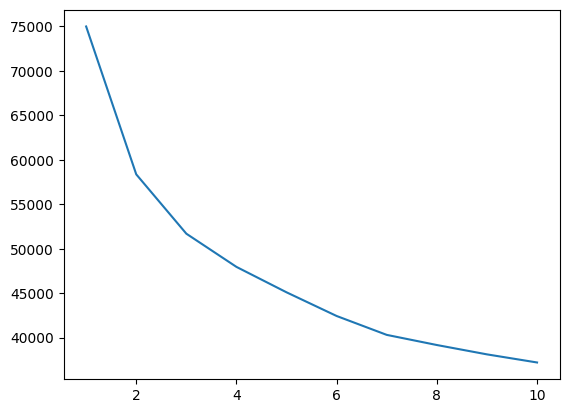

                            customer_id  customer_segment
0  344e452a-50f1-48fe-bdf2-ded44b7d6d8e                 1
1  268a4133-0ec1-4798-8e67-5f8b7c44f7b0                 0
2  5a229ed3-f83b-472a-aa7b-9fbea1cfc5d7                 2
3  3e142dc4-d97e-4b6b-b0cf-a3bfed033f7d                 0
4  f97bb753-d96f-4de1-8b8e-af473399abfd                 2


In [49]:
# Drop irrelevant + non-numeric columns
clustering_data = df_final.drop(columns=[
    'customer_id', 'name', 'occupation', 'gender',
    'marital_status', 'education',
    'Credit Card', 'Home Loan', 'Personal Loan'
], errors='ignore')

print(clustering_data.columns)

# Handle missing values
clustering_data = clustering_data.apply(pd.to_numeric, errors='coerce')
clustering_data.fillna(0, inplace=True)

# Scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Elbow
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.show()

# Optimal clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['customer_segment'] = kmeans.fit_predict(scaled_data)

print(df_final[['customer_id', 'customer_segment']].head())


In [50]:
pd.set_option('display.max_columns', None)
# Assuming df_final is your DataFrame and 'customer_segment' is the column to group by
float_columns = df_final.select_dtypes(include=['int','float'])
grouped_df = float_columns.groupby('customer_segment')

# Summary of each segment
segment_description = grouped_df.describe()
segment_description


age                                                      \
                   count       mean        std   min   25%   50%   75%   max   
customer_segment                                                               
0                 1397.0  43.852541  15.330542  18.0  31.0  43.0  57.0  70.0   
1                 1692.0  44.243499  15.383481  18.0  31.0  45.0  58.0  70.0   
2                 1911.0  43.663004  15.151019  18.0  30.0  44.0  57.0  70.0   

                  salary                                                    \
                   count           mean            std      min        25%   
customer_segment                                                             
0                 1397.0  213606.722978  102286.696038  40294.0  132873.00   
1                 1692.0  205678.059693   97562.983489  40298.0  127305.75   
2                 1911.0   93392.545788   49150.028631  20017.0   55257.50   

                                                loan_amount                 \
                       50%        75%       max       count           mean   
customer_segment                                                             
0                 202200.0  282770.00  449793.0      1397.0  482605.467953   
1                 201899.0  269814.75  449958.0      1692.0  460151.078062   
2                  89508.0  123371.50  299338.0      1911.0  198700.262114   

                                                                        \
                            std           min            25%       50%   
customer_segment                                                         
0                 194004.822936  39958.666667  337792.666667  473574.0   
1                 197460.768249  19530.000000  309794.750000  445922.0   
2                 165866.338818      0.000000   60671.250000  152945.0   

                                          credit_limit                 \
                          75%         max        count           mean   
customer_segment                                                        
0                 617077.5000  1123272.75       1397.0  166164.663800   
1                 597444.1125  1104261.00       1692.0  151565.925128   
2                 317176.5000   948850.00       1911.0   24710.844584   

                                                                         \
                            std  min      25%            50%        75%   
customer_segment                                                          
0                 120444.691326  0.0  68855.0  159614.000000  256366.00   
1                 115630.012630  0.0  45621.5  148309.833333  234002.00   
2                  47818.549995  0.0      0.0       0.000000   31179.75   

                           credit_utilization                           \
                       max              count      mean       std  min   
customer_segment                                                         
0                 449349.0             1397.0  1.223777  0.794204  0.0   
1                 447900.0             1692.0  1.097013  0.758088  0.0   
2                 299094.0             1911.0  0.185120  0.341265  0.0   

                                                         emi_paid              \
                       25%       50%       75%       max    count        mean   
customer_segment                                                                
0                 0.684002  1.222516  1.764520  2.988018   1397.0  128.295634   
1                 0.523577  1.118148  1.628429  2.987327   1692.0  117.793144   
2                 0.000000  0.000000  0.319362  1.947407   1911.0   25.100471   

                                                            tenure_months  \
                        std  min   25%    50%    75%    max         count   
customer_segment                                                            
0                 74.380050  6.0  72.0  114.0  168.0  477.0        1397.0   
1                 67.744361

### Segment Descriptions:
1. **Segment 0: Affluent** :
Higher average salary, loan amount, credit limit, and transaction amounts. These customers have higher financial standing with substantial balances and engagement in high-value transactions.

2. **Segment 1: Cautious** :
Lower loan amounts and credit utilization, fewer enquiries, and lower transaction amounts. This segment seems to manage smaller finances and be more risk-averse or conservative in their credit usage.

3. **Segment 2: Moderate** :
Mid-range loan amounts, credit limits, and financial activity. They display a balanced financial profile with moderate usage across different financial metrics.

## Dynamic Pricing Model

In [51]:
# ----------------------------------------------------------
# CLEAN DUPLICATE COLUMNS + FIX PRODUCT TYPE ENCODING
# ----------------------------------------------------------

# Remove duplicate columns if any
df_final = df_final.loc[:, ~df_final.columns.duplicated()]

# Check if product_type exists before creating dummies
if 'product_type' in df_final.columns:
    df_final = pd.get_dummies(df_final, columns=['product_type'], prefix='', prefix_sep='')

# Ensure final dummy columns exist
for col in ['Credit Card', 'Home Loan', 'Personal Loan']:
    if col not in df_final.columns:
        df_final[col] = 0

# Convert to ints
df_final['Credit Card'] = df_final['Credit Card'].astype(int)
df_final['Home Loan'] = df_final['Home Loan'].astype(int)
df_final['Personal Loan'] = df_final['Personal Loan'].astype(int)

# Remove duplicates again (important!)
df_final = df_final.loc[:, ~df_final.columns.duplicated()]


## Product Recommendation Model

In [52]:
# Assuming df_final is already defined
# Preparing data for classification model
classification_data = df_final.copy()
classification_data.fillna(-888, inplace=True)
# Step 2: Drop unnecessary columns for the model and target columns
X_classification = classification_data.drop(columns=['customer_id', 'name', 'occupation', 'gender', 
                                                     'marital_status', 'education', 'Credit Card', 'Home Loan', 'Personal Loan'])
y_classification = classification_data[['Credit Card', 'Home Loan', 'Personal Loan']]  # Multi-output target columns

# Step 3: Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Step 4: Initialize Random Forest Classifier with MultiOutputClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier = MultiOutputClassifier(rf_classifier)

# Step 5: Train the model on the training data for all three outputs
multi_target_classifier.fit(X_train_class, y_train_class)

# Step 6: Predict probabilities for the test set
y_prob_test = [estimator.predict_proba(X_test_class)[:, 1] for estimator in multi_target_classifier.estimators_]

# Combine probabilities into a DataFrame for easier handling
probabilities = pd.DataFrame({
    'Credit Card': y_prob_test[0],   # Probability for Credit Card
    'Home Loan': y_prob_test[1],     # Probability for Home Loan
    'Personal Loan': y_prob_test[2]  # Probability for Personal Loan
})

# Step 7: Find the most probable product for each customer
most_probable_product = probabilities.idxmax(axis=1)

# Optional: Evaluate model performance
y_pred = multi_target_classifier.predict(X_test_class)
print("\nClassification Report for Credit Card:")
print(classification_report(y_test_class['Credit Card'], y_pred[:, 0]))

print("\nClassification Report for Home Loan:")
print(classification_report(y_test_class['Home Loan'], y_pred[:, 1]))

print("\nClassification Report for Personal Loan:")
print(classification_report(y_test_class['Personal Loan'], y_pred[:, 2]))


Classification Report for Credit Card:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       373
           1       1.00      1.00      1.00       627

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Classification Report for Home Loan:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       385
           1       0.80      0.85      0.82       615

    accuracy                           0.78      1000
   macro avg       0.76      0.75      0.76      1000
weighted avg       0.77      0.78      0.77      1000


Classification Report for Personal Loan:
              precision    recall  f1-score   support

           0       0.68      0.60      0.63       364
           1       0.78      0.84      0.81       636

    accuracy                           0.75      1000
   macro

In [53]:
# Index(['customer_id', 'name', 'age', 'gender', 'marital_status', 'education',
#        'occupation', 'salary', 'loan_amount', 'credit_limit',
#        'credit_utilization', 'emi_paid', 'tenure_months', 'max_dpd',
#        'default_status', 'product_type', 'enquiry_amount',
#        'unique_products_enquired', 'total_enquiries', 'transaction_amount',
#        'account_balance', 'is_salary', 'customer_segment'],
#       dtype='object')

X_classification.columns

Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary',
       'customer_segment'],
      dtype='object')

### Save all the Models

In [54]:
import joblib

# Define the file paths for saving
model_paths = {
    'kmeans': 'models/kmeans_model.pkl',
    'scaler': 'models/scaler.pkl',
    'multi_target_classifier': 'models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'models/rf_regressor_credit_card_model.pkl'
}

# Save models to disk
joblib.dump(kmeans, model_paths['kmeans'])
joblib.dump(scaler, model_paths['scaler'])
joblib.dump(multi_target_classifier, model_paths['multi_target_classifier'])
joblib.dump(rf_regressor_personal_loan, model_paths['rf_regressor_personal_loan'])
joblib.dump(rf_regressor_home_loan, model_paths['rf_regressor_home_loan'])
joblib.dump(rf_regressor_credit_card, model_paths['rf_regressor_credit_card'])

print("Models saved successfully!")

Models saved successfully!


# Combined Code

In [ ]:
import pandas as pd
import joblib

# ----------------------------------------------------------
# LOAD MODELS
# ----------------------------------------------------------
model_paths = {
    'kmeans': 'models/kmeans_model.pkl',
    'scaler': 'models/scaler.pkl',
    'multi_target_classifier': 'models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'models/rf_regressor_credit_card_model.pkl'
}

kmeans = joblib.load(model_paths['kmeans'])
scaler = joblib.load(model_paths['scaler'])
multi_target_classifier = joblib.load(model_paths['multi_target_classifier'])
rf_regressor_personal_loan = joblib.load(model_paths['rf_regressor_personal_loan'])
rf_regressor_home_loan = joblib.load(model_paths['rf_regressor_home_loan'])
rf_regressor_credit_card = joblib.load(model_paths['rf_regressor_credit_card'])

print("Models loaded successfully!")


# ----------------------------------------------------------
# FIXED PROCESSING: MATCH SCALER FEATURES
# ----------------------------------------------------------
def process_customer_data(json_data, scaler):
    # Convert JSON to DataFrame
    customer_data = pd.DataFrame([json_data])

    # Columns to drop ALWAYS (because scaler was NOT trained on them)
    product_cols = ["Credit Card", "Home Loan", "Personal Loan"]

    # Drop product columns if present
    customer_data.drop(columns=[c for c in product_cols if c in customer_data], inplace=True)

    # Prepare clustering input
    clustering_data = customer_data.copy()
    clustering_data.fillna(0, inplace=True)

    # --- CRITICAL FIX ---
    # Force the input to EXACTLY match scaler's expected feature names
    final_df = pd.DataFrame(columns=scaler.feature_names_in_)

    for col in scaler.feature_names_in_:
        if col in clustering_data:
            final_df[col] = clustering_data[col]
        else:
            final_df[col] = 0  # missing → 0

    # Ensure correct order
    final_df = final_df[scaler.feature_names_in_]

    # Scale safely
    scaled_data = scaler.transform(final_df)

    return customer_data, scaled_data





# ----------------------------------------------------------
# PREDICT SEGMENT
# ----------------------------------------------------------
def predict_customer_segment(scaled_data, kmeans):
    return kmeans.predict(scaled_data)[0]


# ----------------------------------------------------------
# FULL PIPELINE
# ----------------------------------------------------------
def recommend_product_and_loan(json_data, kmeans, scaler, multi_target_classifier,
                               rf_regressor_personal_loan, rf_regressor_home_loan,
                               rf_regressor_credit_card):

    customer_data, scaled_data = process_customer_data(json_data, scaler)

    segment = predict_customer_segment(scaled_data, kmeans)
    customer_data['customer_segment'] = segment

    # Classification data
    X_prod = customer_data.copy()
    X_amt = customer_data.copy()

    # FIX: Match classifier training schema
    required_features = multi_target_classifier.estimators_[0].feature_names_in_

    # Add missing
    for col in required_features:
        if col not in X_prod.columns:
            X_prod[col] = 0

    # Remove extra
    X_prod = X_prod[required_features]

    # Predict probabilities
    prob = [est.predict_proba(X_prod)[:, 1] for est in multi_target_classifier.estimators_]

    product_probabilities = pd.Series({
        'Credit Card': prob[0][0],
        'Home Loan': prob[1][0],
        'Personal Loan': prob[2][0]
    })

    best_product = product_probabilities.idxmax()
    best_prob = product_probabilities.max()

    recommendation = f"Recommended Product: {best_product} (Probability: {best_prob:.2f})"

    # ------------------------------------------------------
    # PREDICT LOAN / CREDIT LIMIT
    # ------------------------------------------------------

    # Drop loan_amount if present
    X_amt = X_amt.drop(columns=['loan_amount'], errors='ignore')

    # Credit Card
    if best_product == "Credit Card":
        try:
            amt = rf_regressor_credit_card.predict(X_amt)[0]
            recommendation += f"\nPredicted Credit Limit: ₹{amt:,.2f}"
        except:
            recommendation += "\n⚠️ Credit Card Model Not Trained"

    # Home Loan
    elif best_product == "Home Loan":
        amt = rf_regressor_home_loan.predict(X_amt)[0]
        recommendation += f"\nPredicted Loan Amount: ₹{amt:,.2f}"

    # Personal Loan
    elif best_product == "Personal Loan":
        amt = rf_regressor_personal_loan.predict(X_amt)[0]
        recommendation += f"\nPredicted Loan Amount: ₹{amt:,.2f}"

    if best_prob < 0.5:
        recommendation = "No suitable product recommendations found."

    return recommendation, segment, product_probabilities


# ----------------------------------------------------------
# TEST JSON INPUT
# ----------------------------------------------------------
example_json = {
    'age': 35, 'salary': 50000, 'loan_amount': 0, 'credit_limit': 10000,
    'credit_utilization': 0.3, 'emi_paid': 1000, 'tenure_months': 12,
    'max_dpd': 30, 'default_status': 0, 'enquiry_amount': 1000,
    'unique_products_enquired': 3, 'total_enquiries': 5,
    'transaction_amount': 5000, 'account_balance': 15000, 'is_salary': 1,
    'Credit Card': 1, 'Home Loan': 0, 'Personal Loan': 0
}


# ----------------------------------------------------------
# RUN
# ----------------------------------------------------------
print(recommend_product_and_loan(
    example_json, kmeans, scaler, multi_target_classifier,
    rf_regressor_personal_loan, rf_regressor_home_loan, rf_regressor_credit_card
))


Models loaded successfully!
('Recommended Product: Credit Card (Probability: 0.92)\n⚠️ Credit Card Model Not Trained', 0, Credit Card      0.92
Home Loan        0.48
Personal Loan    0.43
dtype: float64)


## Loading the LLM to generate Insights

In [56]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain.llms import HuggingFacePipeline
from functools import lru_cache

@lru_cache(maxsize=None)
def load_model():
    model_name = "KingNish/Qwen2.5-0.5b-Test-ft"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return tokenizer, model

# Function to generate insights based on customer data
# Function to generate insights based on customer data
def generate_insights(customer_data):
    tokenizer, model = load_model()

    # Create a prompt from the customer data
    prompt = f"""
    Generate a personalized summarised insight about the following customer based on their data:
    
    - Name: {customer_data['name']}
    - Age: {customer_data['age']}
    - Gender: {customer_data['gender']}
    - Marital Status: {customer_data['marital_status']}
    - Education: {customer_data['education']}
    - Occupation: {customer_data['occupation']}
    - Salary: ${customer_data['salary']:,.2f}
    - Loan Amount: ${customer_data['loan_amount']:,.2f}
    - Product Type: {customer_data['product_type']}
    - Credit Limit: ${customer_data['credit_limit']:,.2f}
    - Credit Utilization: {customer_data['credit_utilization']:.2%}
    - EMI Paid: {customer_data['emi_paid']}
    - Tenure Months: {round(float(customer_data['tenure_months']),2)}
    - Max DPD: {customer_data['max_dpd']}
    - Default Status: {int(customer_data['default_status'])}
    - Account Balance: ${customer_data['account_balance']:,.2f}

    Here are the Summarised Insights about {customer_data['name']}:
    """
    # Initialize the query pipeline with increased max_length
    query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        max_length=6000,  # Increase max_length
        max_new_tokens=500,  # Control the number of new tokens generated
        device_map="auto",
    )

    llm = HuggingFacePipeline(pipeline=query_pipeline)

    insights = llm(prompt)
    return insights

In [57]:
import pandas as pd
import json

def df_row_to_json(row):
    data = row.to_dict()
    for key, value in data.items():
        if pd.isnull(value):
            data[key] = None
        elif isinstance(value, pd.Timestamp):
            data[key] = value.isoformat()

    # Convert to JSON string
    json_str = json.dumps(data, indent=4)
    return json_str

# Assuming `merged_data` is a DataFrame and we're converting row 8 to JSON
json_data_str = df_row_to_json(df_final.iloc[6])

# Now convert the JSON string back to a dictionary to access fields
json_data_dict = json.loads(json_data_str)

# insights = generate_insights(json_data_dict)
print(json_data_str)
pd.DataFrame.from_dict(json_data_dict, orient='index').T

{
    "customer_id": "493265ee-98a9-4380-9235-3f8f44d12375",
    "name": "Carol Burns",
    "age": 29.0,
    "gender": "Female",
    "marital_status": "Married",
    "education": "Master",
    "occupation": "Agricultural consultant",
    "salary": 26279,
    "loan_amount": 61251.333333333336,
    "credit_limit": 97631.33333333333,
    "credit_utilization": 0.29152291165698546,
    "emi_paid": 52.0,
    "tenure_months": 41.0,
    "max_dpd": 60.0,
    "default_status": 1.0,
    "enquiry_amount": 0.0,
    "unique_products_enquired": 0.0,
    "total_enquiries": 0.0,
    "transaction_amount": 0.0,
    "account_balance": 9568.290651001345,
    "is_salary": 0.0,
    "Credit Card": 1,
    "Home Loan": 0,
    "Personal Loan": 0,
    "customer_segment": 2
}


,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,credit_utilization,emi_paid,tenure_months,max_dpd,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan,customer_segment
0,493265ee-98a9-4380-9235-3f8f44d12375,Carol Burns,29.0,Female,Married,Master,Agricultural consultant,26279,61251.333333,97631.333333,0.291523,52.0,41.0,60.0,1.0,0.0,0.0,0.0,0.0,9568.290651,0.0,1,0,0,2


In [58]:
!pip install langchain_community

In [59]:
!pip install langchain

In [60]:
!pip install transformers


In [61]:
!pip install torch

In [64]:
import re

# Function to clean unwanted characters and extract the insight
def clean_and_extract_insight(insights):
    # Remove unwanted characters (non-alphanumeric characters except spaces)
    cleaned_insight = re.sub(r'[^a-zA-Z0-9\s]', '', insights)
    
    # Extract the portion after "Summarised Insight"
    if "Here are the Summarised Insights about" in cleaned_insight:
        extracted_insight = cleaned_insight.split("Here are the Summarised Insights about")[1].strip().split("\n\n")[0]
    else:
        extracted_insight = cleaned_insight.strip()

    return extracted_insight

# Example usage
cleaned_insight = clean_and_extract_insight(insights)
print(cleaned_insight.strip())

Customer


In [65]:
data = cleaned_insight.split("\n")[1:]
all_data = list()
for line in data:
    all_data.append(line.strip())

all_data

[]